### Imports

In [26]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'2.4.1'

### Data preprocessing

#### Loading files

Extractiing the zip file

In [3]:
path = './trainingandtestdata.zip'
zip = zipfile.ZipFile(file=path, mode="r")
zip.extractall(path="./")
zip.close()

#### Loading csv files

In [4]:
data_path = './trainingandtestdata/train.csv'

cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

data = pd.read_csv(data_path, header=None, names=cols, engine='python', encoding='latin1')

data.shape

(1600000, 6)

In [5]:
data.head(10)

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [6]:
set(data.sentiment)

{0, 4}

/home/lps/anaconda3/envs/ia/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

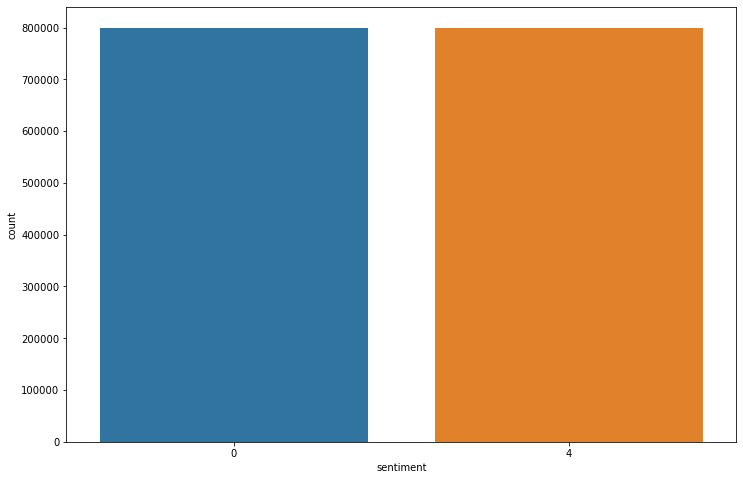

In [7]:
plt.subplots(figsize=(12, 8))
sns.countplot(data.sentiment)

#### Data cleaning

Droping some cols that will not be used

In [8]:
drop_cols = ['id', 'date', 'user', 'query']

data.drop(drop_cols, axis=1, inplace=True)

data.head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


Defining X and y

In [9]:
X = data.iloc[:, 1].values
y = data.iloc[:, 0].values

X.shape, y.shape

((1600000,), (1600000,))

In [10]:
def clean_text(text:str):
    '''Cleaning a input text with nicks, links, tags, numbers and symbols'''
    text = BeautifulSoup(text, 'lxml').get_text()
    # remove user starting with @
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    #remove links
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    #remove numbers, allowing only this caracters below
    text = re.sub(r'[^A-Za-z]', ' ', text)
    #removing extras spaces
    text = re.sub(r' +', ' ', text)
    
    return text

Testing function...

In [11]:
test_text = '@lps08 this its a test! <hr> -= https://github.com/lps08'

clean_text(test_text)

' this its a test '

In [12]:
nlp = sp.load('en_core_web_sm')
stop_words = sp.lang.en.STOP_WORDS

def removing_stopwords(text:str):
    '''Removing stopwords from a input text'''
    text = text.lower()
    document = nlp(text)
    # get text words
    words = [word.text for word in document]
    # removing stopwords
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

Testing function...

In [13]:
removing_stopwords(clean_text(test_text))

'  test'

Aplying funtions to data and verifying if cleaning has been done

In [14]:
file_name = 'data-cleaned.npy'

try:
    # try to load data, if data cleaned was done before
    data_cleaned = np.load(file=file_name)

except:
    # if data cleaning was not done before
    data_cleaned = [removing_stopwords(clean_text(sentense)) for sentense in tqdm(X)]

    np.save(file_name, data_cleaned) 

# showing 4 exemplo of data cleanead
for _ in range(0, 4):
    print(data_cleaned[random.randint(0, len(data_cleaned))])

phormalll phantastic fb days
da start winduk afiqah stay strong
tingly love jesus feeling weekend fb
dam todays wedensday


In [15]:
# changing label 4 to 1
y[y == 4] = 1

In [16]:
np.unique(y)

array([0, 1])

#### Tokenization

In [17]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(corpus_generator=data_cleaned, target_vocab_size=2**16)

In [18]:
print('vocab size: ', tokenizer.vocab_size)

vocab size:  65244


testing tokenizer

In [20]:
to = tokenizer.encode('Im so good')
to

[65061, 3, 14206, 107]

In [21]:
tokenizer.decode(to)

'Im so good'

In [22]:
data_input = [tokenizer.encode(setense) for setense in tqdm(data_cleaned)]

100%|██████████| 1600000/1600000 [00:20<00:00, 77688.43it/s]


In [23]:
# showing 4 exemplo of data input
for _ in range(0, 4):
    print(data_input[random.randint(0, len(data_input))])

[50769, 40257, 82, 47]
[77, 110, 3, 9, 54, 141, 3392, 1453, 144, 1522, 2868, 1535, 3524, 57, 1998, 260, 540, 695]
[1, 17421, 445, 54212, 57, 3242, 6274, 3183]
[325, 238, 46627, 65109]


#### Padding

getting max vocab len in data input

In [24]:
max_len = max([len(setense) for setense in data_input])
print('max len: ', max_len)

max len:  47


applying padding

In [25]:
data_input = tf.keras.preprocessing.sequence.pad_sequences(data_input, value=0, padding='post', maxlen=max_len)

#### Train and test data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data_input, y, test_size=0.3, stratify=y)

In [29]:
X_train.shape, X_test.shape

((1120000, 47), (480000, 47))

In [30]:
y_train.shape, y_test.shape

((1120000,), (480000,))